In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from datetime import datetime
from math import ceil

In [2]:
def start_plot():
    fig, ax = plt.subplots()
    ax.set_xlabel("Czas trwania testu [h]")

    return (fig, ax)

In [3]:
import re

def import_logs(prefix):
    raw_data = []

    pattern = re.compile('.*\[(.*)\].*Type: \[(.*)\].*Name: \[(.*)\].*Time: \[(.*)\].*Status: \[(.*)\]')
    for load_tester_id in range(2, 5 + 1):
        with open(f"{prefix}/load-{load_tester_id}/locust.log") as f:
            for line in f:
                line = line.strip()
                if "Time: " not in line:
                    continue
                match = pattern.match(line)

                statusCode = int(match.group(5))
                time = int(match.group(4))
                name = f"{match.group(2)} {match.group(3)}"
                timestamp = match.group(1)
                raw_data.append((timestamp[:timestamp.find(",")], name, time, statusCode))

    print("parsing data into pandas")
    df = pd.DataFrame(raw_data, columns=['timestamp', 'name', 'time', 'statusCode'])
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df = df.sort_values(by='timestamp')
    start = df['timestamp'][0]
    df['timestamp'] = df['timestamp'].apply(lambda dt: dt - start)
    df.set_index('timestamp', inplace=True, drop=True)
    return df


def human_delta(index):
    return index.get_level_values('timestamp').seconds / 60 / 60

In [7]:
cswo = import_logs('../load-tests/RAW/serverless_burst_non_optimized')
cso = import_logs('../load-tests/RAW/serverless_burst_optimized')
ec2 = import_logs('../load-tests/RAW/ec2_burst_non_optimized/')

cswo = cswo[cswo['statusCode'] != 0]
cso = cso[cso['statusCode'] != 0]
ec2 = ec2[ec2['statusCode'] != 0]

parsing data into pandas
parsing data into pandas
parsing data into pandas


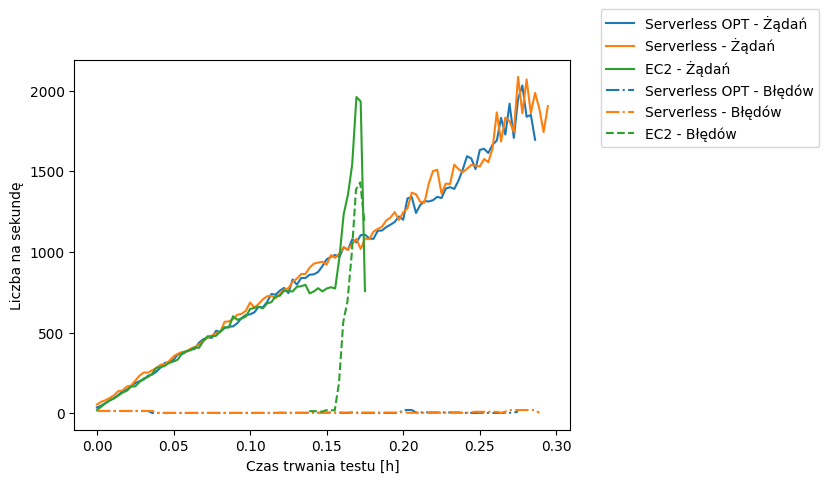

In [51]:
def flatten(df):
    return df.groupby(by='timestamp').count().resample('10s').max().ffill()

def cold_starts_or_errors(df):
    return df[(df['time'] > error_threshold) | (df['statusCode'] == 500)]

# Żądań na sekundę
error_threshold = 3000

fig, ax = start_plot()

df = flatten(cso)
ax.plot(human_delta(df.index), df['name'], color='tab:blue', label='Serverless OPT - Żądań')

df = flatten(cswo)
ax.plot(human_delta(df.index), df['name'], color='tab:orange', label='Serverless - Żądań')

df = flatten(ec2)
ax.plot(human_delta(df.index), df['name'], color='tab:green', label='EC2 - Żądań')

ax2 = ax

df = flatten(cold_starts_or_errors(cso))
ax2.plot(human_delta(df.index), df['name'], '-.', color='tab:blue', label='Serverless OPT - Błędów')

df = flatten(cold_starts_or_errors(cswo))
ax2.plot(human_delta(df.index), df['name'], '-.', color='tab:orange', label='Serverless - Błędów')

df = flatten(cold_starts_or_errors(ec2))
ax2.plot(human_delta(df.index), df['name'], '--', color='tab:green', label='EC2 - Błędów')

ax.set_ylabel('Liczba na sekundę')
fig.legend(bbox_to_anchor=(0.8, 0, 0.5, 1))


In [54]:
cold_starts_or_errors(cso).count(), cold_starts_or_errors(cswo).count(), cold_starts_or_errors(ec2).count()

(name          148
 time          148
 statusCode    148
 dtype: int64,
 name          266
 time          266
 statusCode    266
 dtype: int64,
 name          40795
 time          40795
 statusCode    40795
 dtype: int64)

In [55]:
cold_starts_or_errors(cso).mean(numeric_only=True), cold_starts_or_errors(cswo).mean(numeric_only=True)

(time          5342.777027
 statusCode     210.135135
 dtype: float64,
 time          14479.646617
 statusCode      203.383459
 dtype: float64)

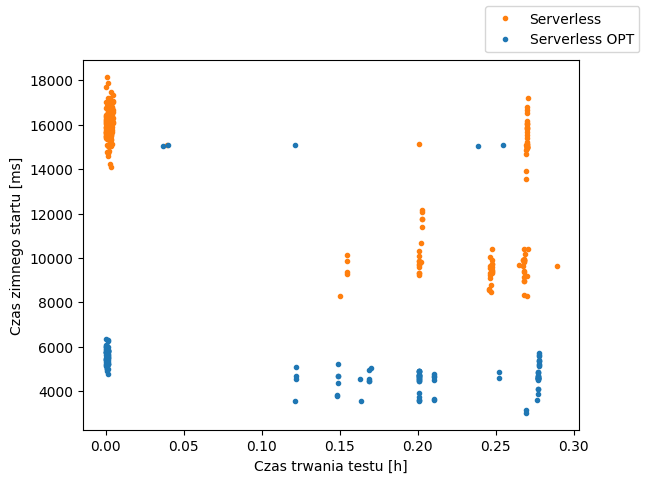

In [72]:

fig, ax = start_plot()
df = cold_starts_or_errors(cswo)
ax.plot(human_delta(df.index), df['time'], '.', label='Serverless', color='tab:orange')

df = cold_starts_or_errors(cso)
ax.plot(human_delta(df.index), df['time'], '.', label='Serverless OPT', color='tab:blue')



ax.set_ylabel('Czas zimnego startu [ms]')
fig.legend()